In [2]:
import nengo
import nengo.spa as spa
import numpy as np
import matplotlib.pyplot as plt
import random

from nengo_learn_assoc_mem.learning_rules.fake_bcm import FakeBCM

%matplotlib inline

In [31]:
t_present = 0.1
n_present = 4
dt = 0.001

n_items = 6
dimensions = 32
n_neurons = 10
intercept = 0.0 # this is assuming the inputs are orthogonal, so shouldn't this be set based off of input_similarity?

In [7]:
# build the vocab
k_vocab = spa.Vocabulary(dimensions)
v_vocab = spa.Vocabulary(dimensions)

for i in range(n_items):
    k_vocab.parse('K%d' % i)
    v_vocab.parse('V%d' % i)

items = list(range(n_items)) * n_present
random.shuffle(items)
vocab_keys = ['K%d' % i for i in items]
vocab_values = ['V%d' % i for i in items]

In [10]:
k_vocab.keys

['K0', 'K1', 'K2', 'K3', 'K4', 'K5']

In [13]:
def gen_feed_func(vocab, vocab_items):

    def f(t):
        index = int(t / t_present)
        index = index % len(vocab_items)
        return vocab.parse(vocab_items[index]).v

    return f

In [43]:
class FakeAssocMem(nengo.Network):

    def __init__(self, n_neurons, dimensions, intercepts,
                 bcm_tau=0.005,
                 bcm_rate=-1e-3,
                 voja_tau=0.005,
                 voja_rate=1e-3,
                 pes_rate=1e-3,
                 seed=None,
                 ):

        super(FakeAssocMem, self).__init__()

        decoders = np.zeros((dimensions, n_neurons), dtype=float)

        self.seed = seed

        with self:
            self.input = nengo.Node(None, size_in=dimensions)
            self.output = nengo.Node(None, size_in=dimensions)
            self.correct = nengo.Node(None, size_in=dimensions)

            self.mem = nengo.Ensemble(n_neurons=n_neurons,
                                      dimensions=dimensions,
                                      intercepts=intercepts,
                                      seed=seed)

            learning_rule_type = nengo.Voja(post_tau=voja_tau, learning_rate=voja_rate)
            self.conn_in = nengo.Connection(self.input, self.mem,
                                            learning_rule_type=learning_rule_type, synapse=None)

            self.fake_bcm = FakeBCM(in_neurons=n_neurons, out_neurons=n_neurons, learning_rate=bcm_rate,
                                   start_weights=np.zeros((n_neurons, n_neurons), dtype=float))
            learn = nengo.Node(self.fake_bcm.bcm_func, size_in=n_neurons*2, size_out=n_neurons)
            nengo.Connection(self.mem.neurons, learn[:n_neurons], synapse=0.005)
            nengo.Connection(self.mem.neurons, learn[n_neurons:], synapse=0.005)
            nengo.Connection(learn, self.mem.neurons, synapse=None)

            learning_rule_type = nengo.PES(learning_rate=pes_rate)
            self.conn_out = nengo.Connection(self.mem.neurons, self.output,
                                             transform=decoders,
                                             learning_rule_type=learning_rule_type)

            self.error = nengo.Node(size_in=dimensions)
            nengo.Connection(self.error, self.conn_out.learning_rule)
            nengo.Connection(self.output, self.error, synapse=None)
            nengo.Connection(self.correct, self.error, transform=-1, synapse=None)

In [60]:
with nengo.Network() as train_model:
    stim = nengo.Node(gen_feed_func(k_vocab, vocab_keys))
    correct = nengo.Node(gen_feed_func(v_vocab, vocab_values))

    mem = FakeAssocMem(n_neurons=10, dimensions=32, intercepts=nengo.dists.Uniform(intercept, intercept), voja_rate=1e-3)
    
    nengo.Connection(stim, mem.input, synapse=None)
    nengo.Connection(correct, mem.correct, synapse=None)
    
    p_out = nengo.Probe(mem.output, synapse=0.01)
    p_ideal = nengo.Probe(correct, synapse=None)
    
    p_dec = nengo.Probe(mem.conn_out, 'weights', sample_every=t_present/2)
    p_enc = nengo.Probe(mem.mem, 'scaled_encoders', sample_every=t_present/2)

In [61]:
with nengo.Simulator(train_model) as train_sim:
    train_sim.run(n_present*n_items*t_present)

enc = train_sim.data[p_enc][-1]
dec = train_sim.data[p_dec][-1]

Building finished in 0:00:01.                                                                                                                             
Simulating finished in 0:00:01.                                                                                                                           


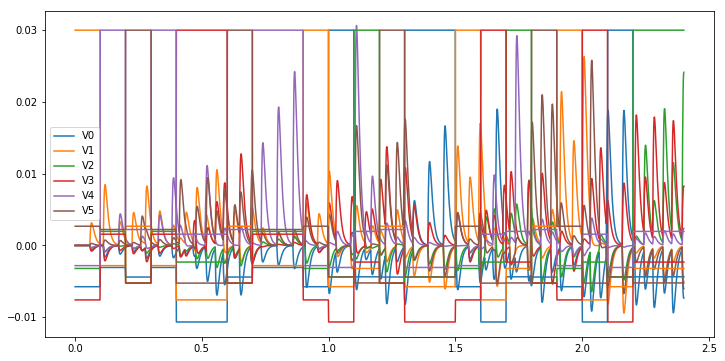

In [70]:
plt.figure(figsize=(12, 6))

plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_out], v_vocab))

plt.gca().set_prop_cycle(None)

plt.plot(train_sim.trange(), spa.similarity(train_sim.data[p_ideal], v_vocab) * 0.03)

plt.legend(v_vocab.keys)



In [63]:
with nengo.Network() as test_model:
    stim = nengo.Node(gen_feed_func(k_vocab, k_vocab.keys))
    correct = nengo.Node(gen_feed_func(v_vocab, v_vocab.keys))

    recall = nengo.Node(size_in=dimensions)

    test_mem = nengo.Ensemble(n_neurons=n_neurons, dimensions=dimensions,
                              encoders=enc,
                              intercepts=nengo.dists.Uniform(intercept, intercept))
    
    nengo.Connection(stim, test_mem, synapse=None)
    nengo.Connection(test_mem.neurons, test_mem.neurons, transform=mem.fake_bcm.weight_history[-1], synapse=0.005)
    nengo.Connection(test_mem.neurons, recall, transform=dec)
    
    p_rec = nengo.Probe(recall, synapse=0.01)
    p_cor = nengo.Probe(correct, synapse=None)

In [64]:
with nengo.Simulator(test_model) as test_sim:
    test_sim.run(n_items*t_present)

Building finished in 0:00:01.                                                                                                                             
Simulating finished in 0:00:01.                                                                                                                           


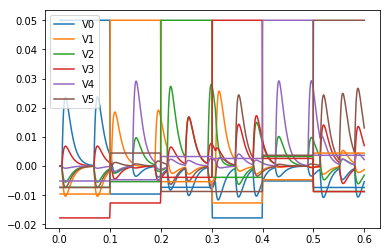

In [66]:
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_rec], v_vocab))
plt.gca().set_prop_cycle(None)
plt.plot(test_sim.trange(), spa.similarity(test_sim.data[p_cor], v_vocab)*0.05)

plt.legend(v_vocab.keys)

In [25]:
# note: this is the equivalent of doing the dot product between both vectors at each time step
accuracy = np.sum(train_sim.data[p_out] * train_sim.data[p_ideal], axis=1)
times = np.arange(n_items * n_present) * t_present
indices = (times / dt).astype(int) - 1 # we want the index right before the switch

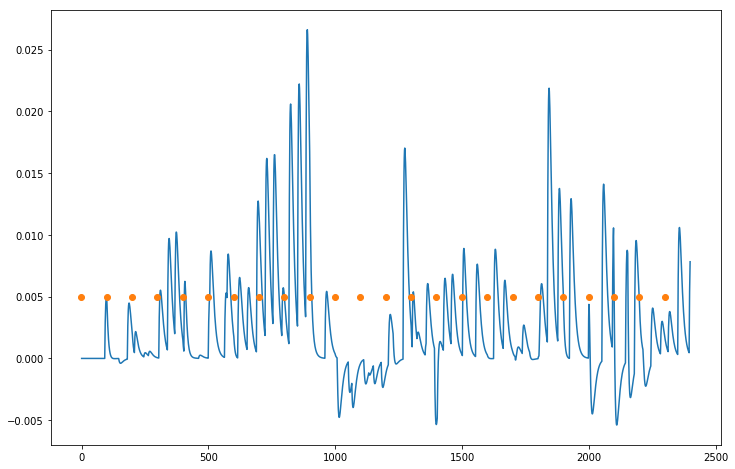

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(accuracy)
plt.plot(indices, np.ones(indices.shape) * 0.005, marker="o", linestyle='None')

In [54]:
times / dt

array([    0.,   100.,   200.,   300.,   400.,   500.,   600.,   700.,
         800.,   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,
        1600.,  1700.,  1800.,  1900.,  2000.,  2100.,  2200.,  2300.])

In [36]:
indices.shape

(24,)

In [37]:
indices

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300])

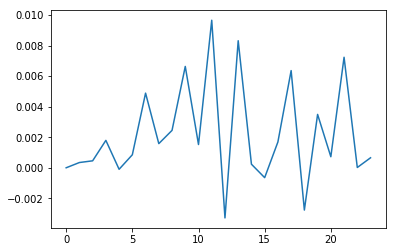

In [38]:
plt.plot(prod[indices])